# File used to plot experiment data

In [88]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import controllers
import numpy as np
import json
import pandas as pd
import controllers
import synthetics
import os
import datetime as dt
from scipy import integrate

In [2]:
def clamp(x, x_min, x_max):
    """Clamps number x between x_min and x_max"""
    if x > x_max:
        return x_max
    if x < x_min:
        return x_min
    return x

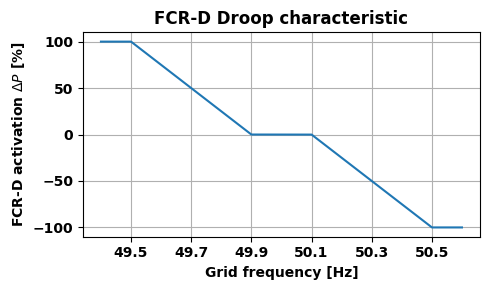

In [3]:
droop = controllers.DroopController(0.4e-2,50,0.1)
fs = np.linspace(49.4,50.6,1000)
activation = [clamp(droop.update(f),-100,100) for f in fs]
plt.figure(figsize=(5,3))
plt.plot(fs,activation)
plt.title('FCR-D Droop characteristic',weight='bold')
plt.xlabel('Grid frequency [Hz]',weight='bold')
plt.ylabel(r'FCR-D activation $\Delta P$ [%]',weight='bold')
plt.xticks([49.5,49.7,49.9,50.1,50.3,50.5],weight='bold')
plt.yticks(weight='bold')
plt.grid(True)
plt.tight_layout()

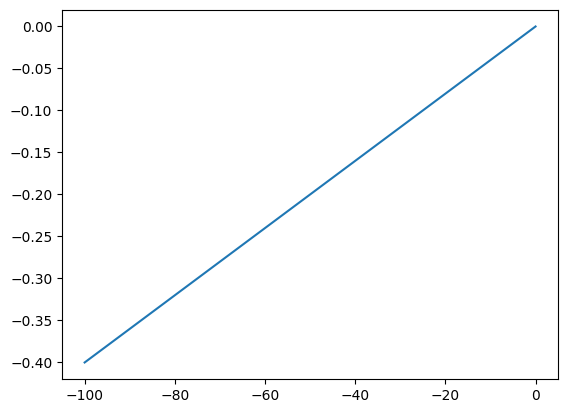

In [4]:
plt.figure()
R = 0.4e-2
activations = np.linspace(0,-100,1000)
fs = R*activations
plt.plot(activations,fs)

In [5]:
filepath = 'tests/' + sorted(os.listdir('tests/'))[-1]
with open(filepath) as file:
    data = [json.loads(line) for line in file]

df = pd.DataFrame.from_records(data)
start = dt.datetime.fromtimestamp(df.loc[df['type']=='start','value'].iloc[0]) - dt.timedelta(hours=1)
stop = dt.datetime.fromtimestamp(df['time_stamp'].iloc[-1]) - dt.timedelta(hours=1)
df = df.loc[df['type'] != 'start']
df['cols'] = (np.array(df['type'].values) + '@' + df['unit'].values)
df_pivot = df.pivot_table(values="value", columns="cols", index="time_stamp")
df_pivot = df_pivot.interpolate(method="linear")
df_pivot.index = pd.to_datetime(df_pivot.index, unit="s")
# Resample the data
df_resampled = df_pivot.resample("s").mean()

# Interpolate the measurements
df_resampled = df_resampled.interpolate()


In [6]:
test = synthetics.FastRampTest(start)
active_bid = 1.5
ts = np.arange(start,stop,dt.timedelta(seconds=0.1)).astype(dt.datetime)
fs = np.array([test.measure_frequency(t) for t in ts])
dfs = fs-50.1
R = 0.4/active_bid
dPs = np.array([clamp(-df/R,-active_bid,0) for df in dfs])

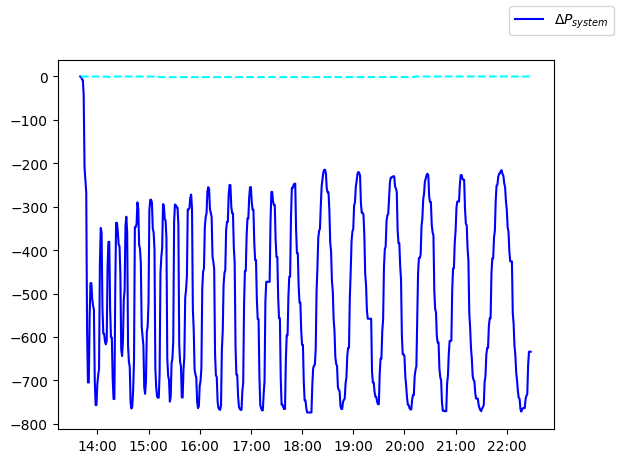

In [7]:
fig,ax1 = plt.subplots()

ax1.plot(df_resampled.index,df_resampled['delta P system@supervisor'],label = r'$\Delta P_{system}$',color='b')
ax1.plot(ts,dPs, color='cyan',linestyle='--')
#ax1.set_xlim(ts[0],ts[8000])
#ax2 = ax1.twinx()
#ax2.plot(df_resampled.index,df_resampled['frequency@supervisor'],label = r'Frequency',color='r')
#ax2.plot(ts,fs,linestyle='--',color='r')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
fig.legend()

In [8]:
df_resampled.columns

Index(['capacity@pi_1', 'delta P supervisor@supervisor',
       'delta P system@supervisor', 'delta P@pi_1', 'droop constant@pi_1',
       'frequency@supervisor'],
      dtype='object', name='cols')

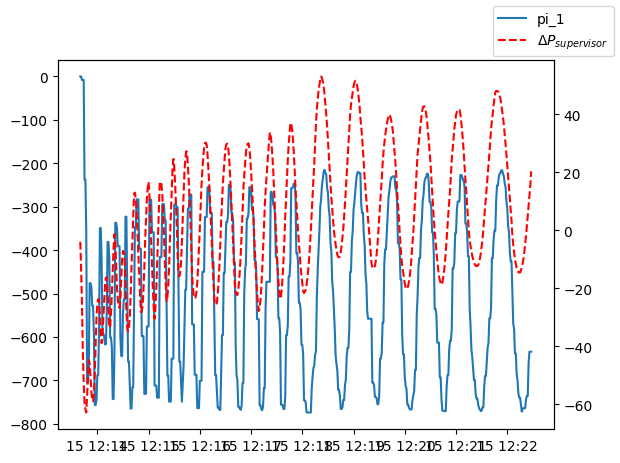

In [9]:
idxs = [c.split('@')[0] == 'delta P' for c in df_resampled.columns]
#df_resampled.iloc[0:800,idxs].plot()
fig, ax1 = plt.subplots()
for c in df_resampled.iloc[:,idxs]:
    ax1.plot(df_resampled.index[0:800],df_resampled[c].iloc[0:800],label = str(c).split('@')[1])
ax2 = ax1.twinx()
ax2.plot(df_resampled.index[0:800],df_resampled['delta P supervisor@supervisor'][0:800],linestyle = '--',color='red',label = r'$\Delta P_{supervisor}$')
fig.legend()

    

Text(0.5, 0.98, 'Initial test for Ki tuning')

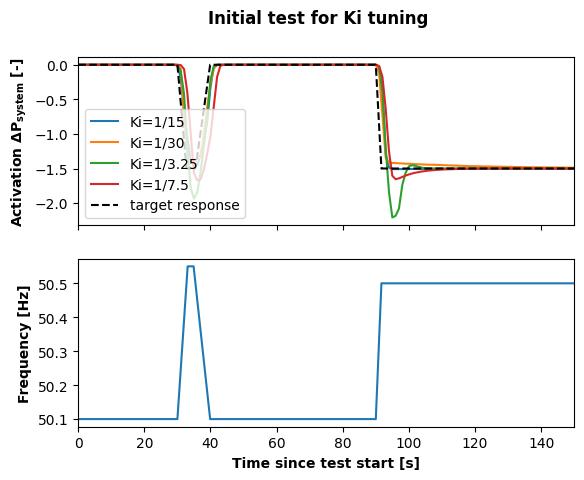

In [10]:
#filepath = 'tests/' + sorted(os.listdir('tests/'))[-1]
fig, axs = plt.subplots(2,1,sharex=True)
for f in os.listdir('saved/'):
    if not f.__contains__('ki'):
        continue
    with open('saved/'+f) as file:
        data = [json.loads(line) for line in file]

    df = pd.DataFrame.from_records(data)
    start = dt.datetime.fromtimestamp(df.loc[df['type']=='start','value'].iloc[0]) - dt.timedelta(hours=1)
    stop = dt.datetime.fromtimestamp(df['time_stamp'].iloc[-1]) - dt.timedelta(hours=1)
    df = df.loc[df['type'] != 'start']
    df['cols'] = (np.array(df['type'].values) + '@' + df['unit'].values)
    df_pivot = df.pivot_table(values="value", columns="cols", index="time_stamp")
    df_pivot = df_pivot.interpolate(method="linear")
    df_pivot.index = pd.to_datetime(df_pivot.index, unit="s")
    # Resample the data
    df_resampled = df_pivot.resample("s").mean()

    # Interpolate the measurements
    df_resampled = df_resampled.interpolate()
    df_resampled['offset'] = (df_resampled.index - df_resampled.index[0]).total_seconds()
    label = 'Ki=1/'+f[2:-5].replace('_','.')
    axs[0].plot(df_resampled['offset'],df_resampled['delta P system@supervisor'],label=label)

start = dt.datetime.now()

test = synthetics.FastRampTest(start)
active_bid = 1.5
ts = np.arange(start,start + dt.timedelta(seconds=200),dt.timedelta(seconds=0.1)).astype(dt.datetime)
toffs = np.array([(t-start).total_seconds() for t in ts])
fs = np.array([test.measure_frequency(t) for t in ts])
dfs = fs-50.1
R = 0.4/active_bid
dPs = np.array([clamp(-df/R,-active_bid,0) for df in dfs])
axs[1].plot(toffs,fs,label = 'frequency')

axs[0].plot(toffs,dPs,color='black',linestyle='--', label = 'target response')
axs[0].set_xlim(0,150)
axs[0].legend()
axs[0].set_ylabel(r'Activation $\mathbf{\Delta P_{system}}$ [-]',weight='bold')
axs[1].set_ylabel('Frequency [Hz]',weight='bold')
axs[1].set_xlabel('Time since test start [s]',weight='bold')
fig.suptitle('Initial test for Ki tuning',weight='bold')

Text(0.5, 0.98, 'Synthetic fast ramp test')

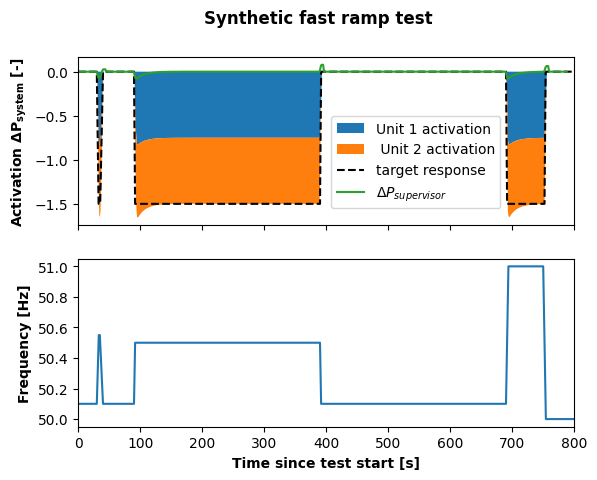

In [176]:
filepath = 'saved/fastramp.json'
#filepath = 'tests/131125,123949.json'
fig, axs = plt.subplots(2,1,sharex=True)
with open(filepath) as file:
    data = [json.loads(line) for line in file]

df = pd.DataFrame.from_records(data)
start = dt.datetime.fromtimestamp(df.loc[df['type']=='start','value'].iloc[0]) - dt.timedelta(hours=1)
stop = dt.datetime.fromtimestamp(df['time_stamp'].iloc[-1]) - dt.timedelta(hours=1)
df = df.loc[df['type'] != 'start']
df['cols'] = (np.array(df['type'].values) + '@' + df['unit'].values)
df_pivot = df.pivot_table(values="value", columns="cols", index="time_stamp")
df_pivot = df_pivot.interpolate(method="linear")
df_pivot.index = pd.to_datetime(df_pivot.index, unit="s")
# Resample the data
df_resampled = df_pivot.resample("s").mean()

# Interpolate the measurements
df_resampled = df_resampled.interpolate()
df_resampled['offset'] = (df_resampled.index - df_resampled.index[0]).total_seconds()
axs[0].stackplot(df_resampled['offset'],df_resampled['delta P@pi_1'],df_resampled['delta P@pi_2'],labels=['Unit 1 activation',' Unit 2 activation'])

start = dt.datetime.now()

test = synthetics.FastRampTest(start)
active_bid = 1.5
ts = np.arange(start,start + dt.timedelta(seconds=800),dt.timedelta(seconds=0.1)).astype(dt.datetime)
toffs = np.array([(t-start).total_seconds() for t in ts])
fs = np.array([test.measure_frequency(t) for t in ts])
dfs = fs-50.1
R = 0.4/active_bid
dPs = np.array([clamp(-df/R,-active_bid,0) for df in dfs])


axs[0].plot(toffs,dPs,color='black',linestyle='--', label = 'target response')
axs[0].plot(df_resampled['offset'],df_resampled['delta P supervisor@supervisor'], label = r'$\Delta P_{supervisor}$')
axs[0].set_xlim(0,800)
axs[0].legend(loc=(0.51,0.1))
axs[0].set_ylabel(r'Activation $\mathbf{\Delta P_{system}}$ [-]',weight='bold')
axs[1].plot(toffs,fs,label = 'frequency')
axs[1].set_ylabel('Frequency [Hz]',weight='bold')
axs[1].set_xlabel('Time since test start [s]',weight='bold')
fig.suptitle('Synthetic fast ramp test',weight='bold')

Text(0.5, 0.98, 'Inverter fast ramp test')

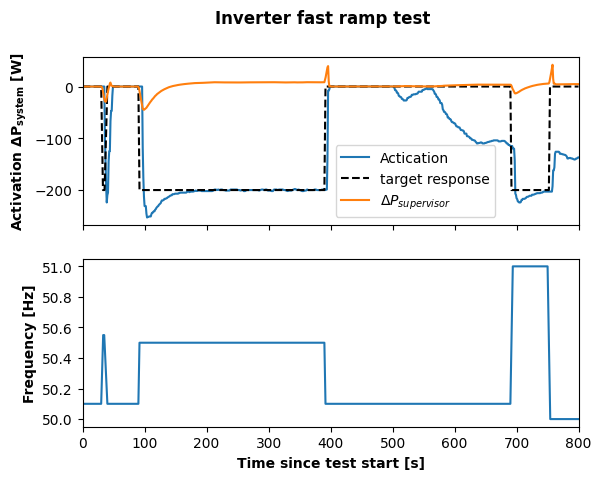

In [179]:
filepath = 'saved/base400bid200.json'
#filepath = 'tests/151125,121322.json'
fig, axs = plt.subplots(2,1,sharex=True)
with open(filepath) as file:
    data = [json.loads(line) for line in file]

df = pd.DataFrame.from_records(data)
start = dt.datetime.fromtimestamp(df.loc[df['type']=='start','value'].iloc[0]) - dt.timedelta(hours=1)
stop = dt.datetime.fromtimestamp(df['time_stamp'].iloc[-1]) - dt.timedelta(hours=1)
df = df.loc[df['type'] != 'start']
df['cols'] = (np.array(df['type'].values) + '@' + df['unit'].values)
df_pivot = df.pivot_table(values="value", columns="cols", index="time_stamp")
df_pivot = df_pivot.interpolate(method="linear")
df_pivot.index = pd.to_datetime(df_pivot.index, unit="s")
# Resample the data
df_resampled = df_pivot.resample("s").mean()

# Interpolate the measurements
df_resampled = df_resampled.interpolate()
df_resampled['offset'] = (df_resampled.index - df_resampled.index[0]).total_seconds()
axs[0].plot(df_resampled['offset'],df_resampled['delta P@pi_1'],label='Actication')

start = dt.datetime.now()

test = synthetics.FastRampTest(start)
active_bid = 200
ts = np.arange(start,start + dt.timedelta(seconds=800),dt.timedelta(seconds=0.1)).astype(dt.datetime)
toffs = np.array([(t-start).total_seconds() for t in ts])
fs = np.array([test.measure_frequency(t) for t in ts])
dfs = fs-50.1
R = 0.4/active_bid
dPs = np.array([clamp(-df/R,-active_bid,0) for df in dfs])


axs[0].plot(toffs,dPs,color='black',linestyle='--', label = 'target response')
axs[0].plot(df_resampled['offset'],df_resampled['delta P supervisor@supervisor'], label = r'$\Delta P_{supervisor}$')
axs[0].set_xlim(0,800)
axs[0].legend(loc=(0.51,0.05))
axs[0].set_ylabel(r'Activation $\mathbf{\Delta P_{system}}$ [W]',weight='bold')
axs[1].plot(toffs,fs,label = 'frequency')
axs[1].set_ylabel('Frequency [Hz]',weight='bold')
axs[1].set_xlabel('Time since test start [s]',weight='bold')
fig.suptitle('Inverter fast ramp test',weight='bold')

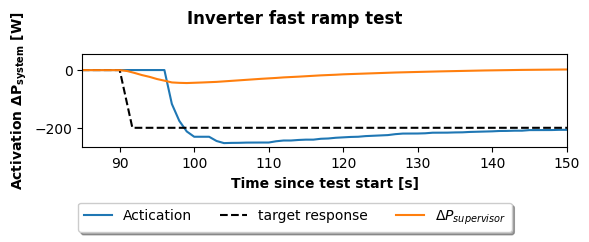

In [154]:
filepath = 'saved/base400bid200.json'
#filepath = 'tests/151125,121322.json'
fig, axs = plt.subplots(figsize=(6,2))
with open(filepath) as file:
    data = [json.loads(line) for line in file]

df = pd.DataFrame.from_records(data)
start = dt.datetime.fromtimestamp(df.loc[df['type']=='start','value'].iloc[0]) - dt.timedelta(hours=1)
stop = dt.datetime.fromtimestamp(df['time_stamp'].iloc[-1]) - dt.timedelta(hours=1)
df = df.loc[df['type'] != 'start']
df['cols'] = (np.array(df['type'].values) + '@' + df['unit'].values)
df_pivot = df.pivot_table(values="value", columns="cols", index="time_stamp")
df_pivot = df_pivot.interpolate(method="linear")
df_pivot.index = pd.to_datetime(df_pivot.index, unit="s")
# Resample the data
df_resampled = df_pivot.resample("s").mean()

# Interpolate the measurements
df_resampled = df_resampled.interpolate()
df_resampled['offset'] = (df_resampled.index - df_resampled.index[0]).total_seconds()
axs.plot(df_resampled['offset'],df_resampled['delta P@pi_1'],label='Actication')

start = dt.datetime.now()

test = synthetics.FastRampTest(start)
active_bid = 200
ts = np.arange(start,start + dt.timedelta(seconds=800),dt.timedelta(seconds=0.1)).astype(dt.datetime)
toffs = np.array([(t-start).total_seconds() for t in ts])
fs = np.array([test.measure_frequency(t) for t in ts])
dfs = fs-50.1
R = 0.4/active_bid
dPs = np.array([clamp(-df/R,-active_bid,0) for df in dfs])


axs.plot(toffs,dPs,color='black',linestyle='--', label = 'target response')
axs.plot(df_resampled['offset'],df_resampled['delta P supervisor@supervisor'], label = r'$\Delta P_{supervisor}$')
axs.set_xlim(85,150)
fig.legend(loc='upper center', bbox_to_anchor=(0.5,0.05),
          fancybox=True, shadow=True, ncol=5)
axs.set_ylabel(r'Activation $\mathbf{\Delta P_{system}}$ [W]',weight='bold')
axs.set_xlabel('Time since test start [s]',weight='bold')
fig.suptitle('Inverter fast ramp test',weight='bold')
fig.tight_layout()

In [ ]:
def overshoot(df:pd.DataFrame,target,start_time,end_time):
    result = df.loc[(df['offset']>=start_time) & (df['offset']<=end_time),'delta P system@supervisor'].min()
    result = abs((result-target)/target)
    return result * 100
overshoot(df_resampled,-2000,90,110)

2.3

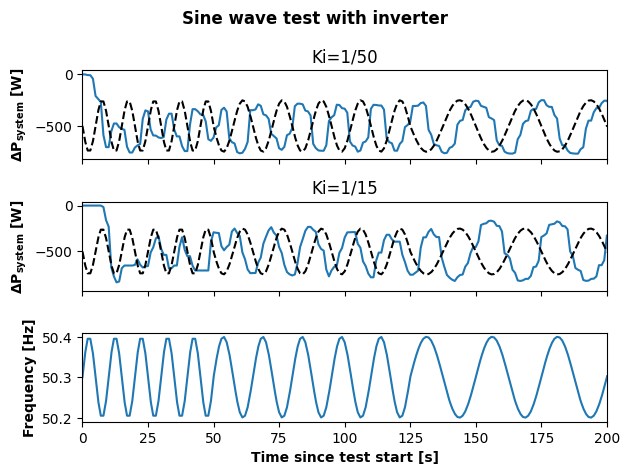

In [173]:
#filepath = 'tests/' + sorted(os.listdir('tests/'))[-1]
fig, axs = plt.subplots(3,1,sharex=True)
i = 0
for f in os.listdir('saved/')[::-1]:
    if not f.__contains__('1000Wsineint'):
        continue
    with open('saved/'+f) as file:
        data = [json.loads(line) for line in file]

    df = pd.DataFrame.from_records(data)
    start = dt.datetime.fromtimestamp(df.loc[df['type']=='start','value'].iloc[0]) - dt.timedelta(hours=1)
    stop = dt.datetime.fromtimestamp(df['time_stamp'].iloc[-1]) - dt.timedelta(hours=1)
    df = df.loc[df['type'] != 'start']
    df['cols'] = (np.array(df['type'].values) + '@' + df['unit'].values)
    df_pivot = df.pivot_table(values="value", columns="cols", index="time_stamp")
    df_pivot = df_pivot.interpolate(method="linear")
    df_pivot.index = pd.to_datetime(df_pivot.index, unit="s")
    # Resample the data
    df_resampled = df_pivot.resample("s").mean()

    # Interpolate the measurements
    df_resampled = df_resampled.interpolate()
    df_resampled['offset'] = (df_resampled.index - df_resampled.index[0]).total_seconds()
    label = 'Ki=1/'+f[2:-5].replace('_','.')
    axs[i].plot(df_resampled['offset'],df_resampled['delta P system@supervisor'],label=label)
    i += 1

start = dt.datetime.now()

test = synthetics.sine_test('sine_test.csv',start)
active_bid = 1000
ts = np.arange(start,start + dt.timedelta(seconds=1350),dt.timedelta(seconds=0.1)).astype(dt.datetime)
toffs = np.array([(t-start).total_seconds() for t in ts])
fs = np.array([test.measure_frequency(t) for t in ts])
dfs = fs-50.1
R = 0.4/active_bid
dPs = np.array([clamp(-df/R,-active_bid,0) for df in dfs])
axs[2].plot(toffs,fs,label = 'frequency')

axs[0].plot(toffs,dPs,color='black',linestyle='--', label = 'target response')
axs[1].plot(toffs,dPs,color='black',linestyle='--', label = 'target response')
axs[0].set_xlim(0,200)
#axs[0].legend()
axs[0].set_ylabel(r'$\mathbf{\Delta P_{system}}$ [W]',weight='bold')
axs[1].set_ylabel(r'$\mathbf{\Delta P_{system}}$ [W]',weight='bold')
axs[2].set_ylabel('Frequency [Hz]',weight='bold')
axs[2].set_xlabel('Time since test start [s]',weight='bold')
axs[0].set_title('Ki=1/50')
axs[1].set_title('Ki=1/15')
fig.suptitle('Sine wave test with inverter',weight='bold')
fig.tight_layout()

Text(0.5, 1.0, 'Sine test frequency signal')

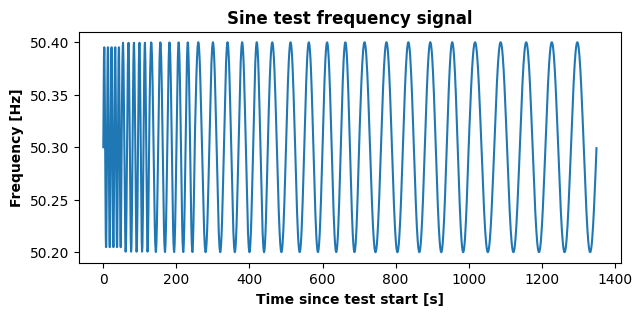

In [38]:
start = dt.datetime.now()

test = synthetics.sine_test('sine_test.csv',start)
active_bid = 1000
ts = np.arange(start,start + dt.timedelta(seconds=1350),dt.timedelta(seconds=0.1)).astype(dt.datetime)
toffs = np.array([(t-start).total_seconds() for t in ts])
fs = np.array([test.measure_frequency(t) for t in ts])
dfs = fs-50.1
R = 0.4/active_bid
dPs = np.array([clamp(-df/R,-active_bid,0) for df in dfs])

plt.figure(figsize=(7,3))
plt.plot(toffs,fs)
plt.ylabel('Frequency [Hz]',weight='bold')
plt.xlabel('Time since test start [s]',weight='bold')
plt.title('Sine test frequency signal',weight='bold')

In [122]:
def req_one(df:pd.DataFrame,target):
    Pss3 = df.loc[(df['offset']<390),'delta P system@supervisor'].iloc[-1]
    Pss4 = df.loc[(df['offset']<690),'delta P system@supervisor'].iloc[-1]
    result = (Pss3-Pss4+abs(target))/abs(target)
    check = (result >= -0.2) & (result <= 0.05)
    return float(result),bool(check)
def req_two(df:pd.DataFrame,target):
    Ps = df['delta P system@supervisor']
    ts = df['offset']
    t7_5 = 690 + 7.5
    P7_5 = np.interp(t7_5,ts,Ps)
    check1 = abs(P7_5) >= 0.86 * abs(target)
    t60 = 690 + 60
    check2 = abs(df.loc[(df['offset']>= t7_5) & (df['offset']<= t60),'delta P system@supervisor'].max()) >= 0.86 * abs(target)
    return float(P7_5),bool(check1),bool(check2)
def req_three(df:pd.DataFrame,target):
    t0 = 690
    t7_5 = t0 + 7.5
    df_act = df.loc[(df['offset']>= t0) & (df['offset']<= t7_5)]
    E7_5 = integrate.trapezoid(df_act['delta P system@supervisor'],x=df_act['offset'])
    check = abs(E7_5) >= abs(target * 3.2)
    return E7_5,bool(check)
def req_four(df:pd.DataFrame,target):
    tzenith = 30 + 4.4
    df_act = df.loc[(df['offset']>= tzenith) & (df['offset']<= tzenith + 40)]
    Ps = df_act['delta P system@supervisor']
    ts = df_act['offset']
    Pzenith = np.interp(tzenith,ts,Ps)
    integrant = min(abs(Pzenith),0.5*abs(target))
    value = np.max(integrate.cumulative_trapezoid(ts,-Ps-integrant))
    check = value <= 1.7*abs(target)
    return value,bool(check)
def req_all(df:pd.DataFrame,target):
    r1 = req_one(df,target)
    r2 = req_two(df,target)
    r3 = req_three(df,target)
    r4 = req_four(df,target)
    
    passed = [r1[1],(r2[1] & r2[2]),r3[1],r4[1]]
    return passed
    

Ki=1/50  Requirements [True, True, False, False]
Ki=1/300  Requirements [True, False, False, False]
Ki=1/150  Requirements [True, False, False, False]
Ki=0  Requirements [True, False, False, False]


Text(0.5, 0.98, 'Inverter fast ramp test with variable baseline')

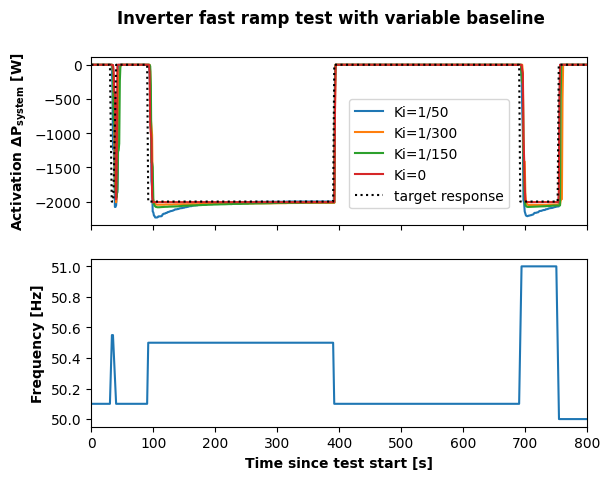

In [135]:
#filepath = 'tests/' + sorted(os.listdir('tests/'))[-1]
fig, axs = plt.subplots(2,1,sharex=True)

start = dt.datetime.now()

test = synthetics.FastRampTest(start)
active_bid = 2000
ts = np.arange(start,start + dt.timedelta(seconds=800),dt.timedelta(seconds=0.1)).astype(dt.datetime)
toffs = np.array([(t-start).total_seconds() for t in ts])
fs = np.array([test.measure_frequency(t) for t in ts])
dfs = fs-50.1
R = 0.4/active_bid
dPs = np.array([clamp(-df/R,-active_bid,0) for df in dfs])

for f in os.listdir('saved/')[-1:0:-1]:
    if not f.__contains__('2000Wadaptbaselineint'):
        continue
    with open('saved/'+f) as file:
        data = [json.loads(line) for line in file]

    df = pd.DataFrame.from_records(data)
    start = dt.datetime.fromtimestamp(df.loc[df['type']=='start','value'].iloc[0]) - dt.timedelta(hours=1)
    stop = dt.datetime.fromtimestamp(df['time_stamp'].iloc[-1]) - dt.timedelta(hours=1)
    df = df.loc[df['type'] != 'start']
    df['cols'] = (np.array(df['type'].values) + '@' + df['unit'].values)
    df_pivot = df.pivot_table(values="value", columns="cols", index="time_stamp")
    df_pivot = df_pivot.interpolate(method="linear")
    df_pivot.index = pd.to_datetime(df_pivot.index, unit="s")
    # Resample the data
    df_resampled = df_pivot.resample("s").mean()

    # Interpolate the measurements
    df_resampled = df_resampled.interpolate()
    df_resampled['offset'] = (df_resampled.index - df_resampled.index[0]).total_seconds()
    label = 'Ki=1/'+f[21:-5].replace('_','.')
    if label == 'Ki=1/0':
        label = 'Ki=0'
    axs[0].plot(df_resampled['offset'],df_resampled['delta P system@supervisor'],label=label)
    passed = req_all(df_resampled,-2000)
    print(label," Requirements", passed)


axs[0].plot(toffs,dPs,color='black',linestyle=':', label = 'target response')

axs[0].set_xlim(0,800)
axs[0].legend(loc=(0.52,0.1))
axs[1].plot(toffs,fs,label = 'frequency')

axs[0].set_ylabel(r'Activation $\mathbf{\Delta P_{system}}$ [W]',weight='bold')
axs[1].set_ylabel('Frequency [Hz]',weight='bold')
axs[1].set_xlabel('Time since test start [s]',weight='bold')
fig.suptitle('Inverter fast ramp test with variable baseline',weight='bold')

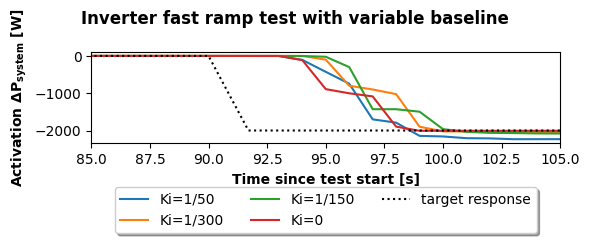

In [171]:
#filepath = 'tests/' + sorted(os.listdir('tests/'))[-1]
fig, axs = plt.subplots(figsize=(6,3))

start = dt.datetime.now()

test = synthetics.FastRampTest(start)
active_bid = 2000
ts = np.arange(start,start + dt.timedelta(seconds=800),dt.timedelta(seconds=0.1)).astype(dt.datetime)
toffs = np.array([(t-start).total_seconds() for t in ts])
fs = np.array([test.measure_frequency(t) for t in ts])
dfs = fs-50.1
R = 0.4/active_bid
dPs = np.array([clamp(-df/R,-active_bid,0) for df in dfs])

for f in os.listdir('saved/')[-1:0:-1]:
    if not f.__contains__('2000Wadaptbaselineint'):
        continue
    with open('saved/'+f) as file:
        data = [json.loads(line) for line in file]

    df = pd.DataFrame.from_records(data)
    start = dt.datetime.fromtimestamp(df.loc[df['type']=='start','value'].iloc[0]) - dt.timedelta(hours=1)
    stop = dt.datetime.fromtimestamp(df['time_stamp'].iloc[-1]) - dt.timedelta(hours=1)
    df = df.loc[df['type'] != 'start']
    df['cols'] = (np.array(df['type'].values) + '@' + df['unit'].values)
    df_pivot = df.pivot_table(values="value", columns="cols", index="time_stamp")
    df_pivot = df_pivot.interpolate(method="linear")
    df_pivot.index = pd.to_datetime(df_pivot.index, unit="s")
    # Resample the data
    df_resampled = df_pivot.resample("s").mean()

    # Interpolate the measurements
    df_resampled = df_resampled.interpolate()
    df_resampled['offset'] = (df_resampled.index - df_resampled.index[0]).total_seconds()
    label = 'Ki=1/'+f[21:-5].replace('_','.')
    if label == 'Ki=1/0':
        label = 'Ki=0'
    axs.plot(df_resampled['offset'],df_resampled['delta P system@supervisor'],label=label)


axs.plot(toffs,dPs,color='black',linestyle=':', label = 'target response')

axs.set_xlim(85,105)
axs.legend(loc='upper center', bbox_to_anchor=(0.5,-0.4),
          fancybox=True, shadow=True, ncol=3)

axs.set_ylabel(r'Activation $\mathbf{\Delta P_{system}}$ [W]',weight='bold')
axs.set_xlabel('Time since test start [s]',weight='bold')
fig.suptitle('Inverter fast ramp test with variable baseline',weight='bold')
fig.tight_layout()